### Projeto com Feedback - 03
### Prevendo Satisfação dos Clientes Santander
#### Autor: Glauco Júnior Carvalho

#### O Santander, terceiro maior banco privado do Sistema Financeiro Nacional, tem como medida de sucesso a satisfação do cliente. 

##### Levando em consideração que os clientes insatisfeitos raramente expressam a sua insatisfação antes de sair, o Santander solicitou o desenvolvimento de um algoritmo para identificar os clientes insatisfeitos antes que seja tarde demais.

In [1]:
# Importando bibliotecas
import pandas as pd

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregando o conjunto de dados
dataframe = pd.read_csv('dataset.csv')

In [3]:
# Visualizando as 5 primeiras linhas do conjunto de dados
dataframe.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


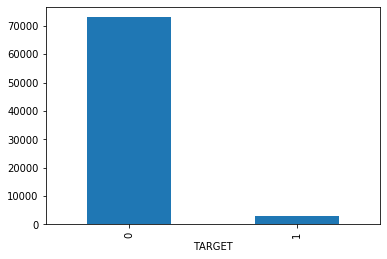

In [4]:
# Agrupando o cojunto de dados pela variável TARGET para saber como os dados estão distribuídos
resume_target = dataframe.groupby('TARGET').size()
resume_target.plot(kind = 'bar')

Podemos analisar que existem mais dados com o valor 0 (ainda bem), esse valor 0 significa os clientes satisfeitos, já os resultados com valor 1 representa os clientes insatisfeitos.

O objetivo do algoritmo é prever esses clientes insatisfeitos e tentar não perdê-los como clientes.

In [5]:
# Criando uma lista das variáveis constantes com desvio padrão igual a 0
columns_std0 = []
columns_std0 = [x for x in dataframe.columns if dataframe[x].std() == 0]
len(columns_std0)

34

Nós temos 34 variáveis constantes, isso pode atrapalhar mais o nosso algoritmo, então vamos removê-las.

In [6]:
# Deletando colunas que possuem valores constantes
for col in columns_std0:
    del dataframe[col]
    print('Coluna: ', col, " deletada com sucesso!")

Coluna:  ind_var2_0  deletada com sucesso!
Coluna:  ind_var2  deletada com sucesso!
Coluna:  ind_var27_0  deletada com sucesso!
Coluna:  ind_var28_0  deletada com sucesso!
Coluna:  ind_var28  deletada com sucesso!
Coluna:  ind_var27  deletada com sucesso!
Coluna:  ind_var41  deletada com sucesso!
Coluna:  ind_var46_0  deletada com sucesso!
Coluna:  ind_var46  deletada com sucesso!
Coluna:  num_var27_0  deletada com sucesso!
Coluna:  num_var28_0  deletada com sucesso!
Coluna:  num_var28  deletada com sucesso!
Coluna:  num_var27  deletada com sucesso!
Coluna:  num_var41  deletada com sucesso!
Coluna:  num_var46_0  deletada com sucesso!
Coluna:  num_var46  deletada com sucesso!
Coluna:  saldo_var28  deletada com sucesso!
Coluna:  saldo_var27  deletada com sucesso!
Coluna:  saldo_var41  deletada com sucesso!
Coluna:  saldo_var46  deletada com sucesso!
Coluna:  imp_amort_var18_hace3  deletada com sucesso!
Coluna:  imp_amort_var34_hace3  deletada com sucesso!
Coluna:  imp_reemb_var13_hace3  

In [7]:
# Conhecendo o shape dos dados
dataframe.shape

(76020, 337)

In [8]:
# Conhecendo os resumos estatísticos das variáveis
dataframe.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [9]:
# Verificando se possui colunas duplicadas
col_unique = []
col_names = [col_unique.append(x) for x in dataframe.columns if x not in col_unique]
len(col_unique)

337

In [10]:
# Conhecendo os tipos dos dados
dataframe.dtypes

ID                           int64
var3                         int64
var15                        int64
imp_ent_var16_ult1         float64
imp_op_var39_comer_ult1    float64
                            ...   
saldo_medio_var44_hace3    float64
saldo_medio_var44_ult1     float64
saldo_medio_var44_ult3     float64
var38                      float64
TARGET                       int64
Length: 337, dtype: object

In [11]:
# Separando o nosso conjunto de dados nas variáveis preditoras e a variável TARGET
X = dataframe.drop(['TARGET', 'ID'], axis = 1)
Y = dataframe['TARGET'].to_frame()

In [12]:
# Criação de modelo para saber quais variáveis mais importantes (feature selection)
model = ExtraTreesClassifier()
model.fit(X,Y)

feature_selection = pd.DataFrame([dataframe.columns[1:336], model.feature_importances_])

O ExtraTreesClassifier é um algoritmo de classificação que testa divisões randomizadas de árvores de decisão.

In [13]:
# Verificando o resumo de importância das variáveis
feature_selection.head()

,0,1,2,3,4,5,6,7,8,9,...,325,326,327,328,329,330,331,332,333,334
0,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
1,0.00347171,0.152369,0.00354485,0.00323762,0.00361542,9.67709e-05,8.96658e-05,0.000290028,0.000289345,0.000106213,...,7.00502e-08,2.44165e-06,6.0161e-07,2.26384e-06,1.92245e-06,2.77191e-06,2.22688e-06,2.32112e-05,2.68159e-05,0.408885


In [14]:
# Transformando o resultado das variáveis na sua transposta 
# ordenando da "melhor" para a "pior" e obtendo apenas as 20
# que tiverem os melhores resultados
resume_t = feature_selection.T.sort_values(1, ascending = False).head(20)
resume_t

,0,1
334,var38,0.408885
1,var15,0.152369
296,saldo_medio_var5_hace3,0.0254102
298,saldo_medio_var5_ult3,0.0243528
294,num_var45_ult3,0.0208157
292,num_var45_hace3,0.0193674
291,num_var45_hace2,0.0165657
249,num_var22_ult3,0.0133327
295,saldo_medio_var5_hace2,0.0131466
293,num_var45_ult1,0.0129601


Com o objetivo de diminuir o processamento, podemos filtrar as 20 variáveis que se saíram melhor na nossa análise de feature selection, facilitando assim na hora de implementar o algoritmo de predição.

In [15]:
# Criando uma lista das TOP 20 variáveis
columns_name = [x for x in resume_t[0]]

In [16]:
# Removendo as colunas que se saíram "piores" no nosso teste de feature selection
drop_columns_list = [n for n in X if n not in columns_name]

for col in drop_columns_list:
    del X[col]
    print('Coluna: ', col, " deletada com sucesso!")

Coluna:  var3  deletada com sucesso!
Coluna:  imp_ent_var16_ult1  deletada com sucesso!
Coluna:  imp_op_var39_comer_ult1  deletada com sucesso!
Coluna:  imp_op_var39_comer_ult3  deletada com sucesso!
Coluna:  imp_op_var40_comer_ult1  deletada com sucesso!
Coluna:  imp_op_var40_comer_ult3  deletada com sucesso!
Coluna:  imp_op_var40_efect_ult1  deletada com sucesso!
Coluna:  imp_op_var40_efect_ult3  deletada com sucesso!
Coluna:  imp_op_var40_ult1  deletada com sucesso!
Coluna:  imp_op_var41_comer_ult1  deletada com sucesso!
Coluna:  imp_op_var41_comer_ult3  deletada com sucesso!
Coluna:  imp_op_var41_efect_ult1  deletada com sucesso!
Coluna:  imp_op_var41_efect_ult3  deletada com sucesso!
Coluna:  imp_op_var41_ult1  deletada com sucesso!
Coluna:  imp_op_var39_efect_ult1  deletada com sucesso!
Coluna:  imp_op_var39_efect_ult3  deletada com sucesso!
Coluna:  imp_op_var39_ult1  deletada com sucesso!
Coluna:  imp_sal_var16_ult1  deletada com sucesso!
Coluna:  ind_var1_0  deletada com suces

Coluna:  delta_num_reemb_var17_1y3  deletada com sucesso!
Coluna:  delta_num_reemb_var33_1y3  deletada com sucesso!
Coluna:  delta_num_trasp_var17_in_1y3  deletada com sucesso!
Coluna:  delta_num_trasp_var17_out_1y3  deletada com sucesso!
Coluna:  delta_num_trasp_var33_in_1y3  deletada com sucesso!
Coluna:  delta_num_trasp_var33_out_1y3  deletada com sucesso!
Coluna:  delta_num_venta_var44_1y3  deletada com sucesso!
Coluna:  imp_amort_var18_ult1  deletada com sucesso!
Coluna:  imp_amort_var34_ult1  deletada com sucesso!
Coluna:  imp_aport_var13_hace3  deletada com sucesso!
Coluna:  imp_aport_var13_ult1  deletada com sucesso!
Coluna:  imp_aport_var17_hace3  deletada com sucesso!
Coluna:  imp_aport_var17_ult1  deletada com sucesso!
Coluna:  imp_aport_var33_hace3  deletada com sucesso!
Coluna:  imp_aport_var33_ult1  deletada com sucesso!
Coluna:  imp_var7_emit_ult1  deletada com sucesso!
Coluna:  imp_var7_recib_ult1  deletada com sucesso!
Coluna:  imp_compra_var44_hace3  deletada com suce

### Chegamos na parte de treinar os nossos modelos, utilizaremos 4 tipos de algoritmos e por fim fazemos uma análise de qual algoritmo se saiu melhor.

Para validação e teste dos nossos modelos, trabalharemos com cross-validation (validação cruzada) que testa a generalização do nosso modelo dado um conjunto de dados. Utilizaremos o método K-Fold para dividir os nossos particionamentos e realizar o teste para cada subconjunto.

In [17]:
# REGRESSÃO LOGÍSTICA
num_folds = 10
seed = 2020

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
model_LR = LogisticRegression()

# Cross Validation
result_LR = cross_val_score(model_LR, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (result_LR.mean() * 100))

Acurácia: 96.041


In [18]:
# LINEAR DISCRIMINANT ANALYSIS
num_folds = 10
seed = 2021

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
model_LDA = LinearDiscriminantAnalysis()

# Cross Validation
result_LDA = cross_val_score(model_LDA, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (result_LDA.mean() * 100))

Acurácia: 95.910


In [19]:
# KNN
num_folds = 10
random_state = 2022

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = random_state)

# Criando o modelo
model_KNN = KNeighborsClassifier()

# Cross Validation
result_KNN = cross_val_score(model_KNN, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (result_KNN.mean() * 100))

Acurácia: 95.866


In [20]:
# NAIVE BAYES
num_folds = 10
seed = 2023

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
model_NB = GaussianNB()

# Cross Validation
result_NB = cross_val_score(model_NB, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (result_NB.mean() * 100))

Acurácia: 13.637


In [21]:
# Criando um dicionário com os resultados
dict_results = [{'Tipo': 'Linear', 'Algoritmo': 'LR', 'Acurácia': result_LR.mean() * 100},
                 {'Tipo': 'Linear', 'Algoritmo': 'LDA', 'Acurácia': result_LDA.mean() * 100},
                 {'Tipo': 'Não Linear', 'Algoritmo': 'KNN', 'Acurácia': result_KNN.mean() * 100},
                 {'Tipo': 'Não Linear', 'Algoritmo': 'NB', 'Acurácia': result_NB.mean() * 100}]
df_results = pd.DataFrame.from_dict(dict_results)

In [22]:
df_results

,Tipo,Algoritmo,Acurácia
0,Linear,LR,96.040516
1,Linear,LDA,95.910287
2,Não Linear,KNN,95.865562
3,Não Linear,NB,13.637201


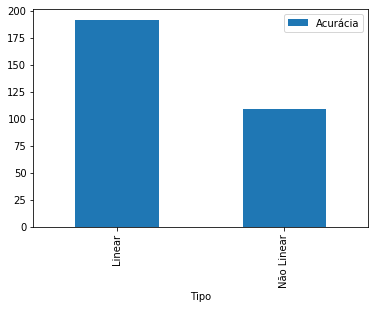

In [23]:
df_results.groupby('Tipo').sum().plot(kind="bar")

Para concluir o nosso projeto, podemos analisar que os algoritmos Lineares se saíram melhores em nossos testes.


Precisamente o algoritmo de Regressão Logística obteve a melhor acurácia, sendo eleito neste problema como o melhor algoritmo para ajudar o Santander na gestão dos seus clientes.


É de fundamental importância lembrar que cada problema de negócio terá o seu melhor modelo e técnicas.

